In [1]:
# Preload the interleaf data 
from datasets import load_dataset

ds = load_dataset("nvidia/HelpSteer")

train = ds['train'] # len(train) = 35331 (95%)
df = train.to_pandas()

/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
grouped = df.groupby(['prompt'])
filtered_df = grouped.filter(lambda x: len(x) >= 2)
len(filtered_df), len(df)

(34657, 35331)

In [3]:
df['Output'] = df['response']
del df['response']

In [4]:
df.rename(columns=lambda x: x.capitalize(), inplace=True)


In [5]:
import pandas as pd
import numpy as np

# Assuming df is your original DataFrame
new_rows = []

# Group the DataFrame by 'image'
for image, group in df.groupby(['Prompt']):
    # Find the 'GPT4V_response' and candidate responses within this group
    candidate_responses = group
    # If there are no candidate responses, skip this group
    if candidate_responses.empty:
        continue
    
    # Calculate the difference in the total sum of 'Helpfulness', 'Correctness', and 'Coherence'
    candidate_responses['Sum_quality'] = candidate_responses['Helpfulness'] + candidate_responses['Correctness'] + candidate_responses['Coherence']
    diff = abs(max(candidate_responses['Sum_quality']) - min(candidate_responses['Sum_quality']))
    
    # If the difference is too small, skip this group
    if diff < 2:  # Define your threshold
        continue
    
    # Find the response with the highest 'Sum_quality'
    max_row_index = candidate_responses['Sum_quality'].idxmax()
    max_row = candidate_responses.loc[max_row_index]
    
    # Filter for responses that are at least 2 lesser or equal
    filtered_responses = candidate_responses[candidate_responses['Sum_quality'] <= max_row['Sum_quality'] - 2]
    
    # If the filtered group is empty, skip this group
    if filtered_responses.empty:
        continue
    
    # Randomly sample one response from the filtered group
    selected_row = filtered_responses.sample(n=1)
    # Create a new row with the 'GPT4V_response' and the selected candidate response
    new_row = {
        'question': max_row['Prompt'],
        # 'GPT4V_question_and_response': max_row['conversations'],  # Add 'conversations' column
        'chosen': max_row['Output'],
        # 'Candidate_question_and_response': selected_row['conversations'],  # Add 'conversations' column
        'rejected': selected_row['Output'].item(),
        'Helpfulness_gpt4v': max_row['Helpfulness'],
        'Correctness_gpt4v': max_row['Correctness'],
        'Coherence_gpt4v': max_row['Coherence'],
        'Sum_of_helpfulness_correctness_coherence_gpt4v': max_row['Helpfulness'] + max_row['Correctness'] + max_row['Coherence'],
        'Complexity_gpt4v': max_row['Complexity'],
        'Verbosity_gpt4v': max_row['Verbosity'],
        'Helpfulness_candidate': selected_row['Helpfulness'].values[0],
        'Correctness_candidate': selected_row['Correctness'].values[0],
        'Coherence_candidate': selected_row['Coherence'].values[0],
        'Sum_of_helpfulness_correctness_coherence_candidate': selected_row['Helpfulness'].values[0] + selected_row['Correctness'].values[0] + selected_row['Coherence'].values[0],
        'Complexity_candidate': selected_row['Complexity'].values[0],
        'Verbosity_candidate': selected_row['Verbosity'].values[0],
    }
    
    new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)
sum_attributes = ['Sum_of_helpfulness_correctness_coherence_gpt4v', 
 'Sum_of_helpfulness_correctness_coherence_candidate']
new_df[sum_attributes].describe()

/tmp/ipykernel_111594/3407610649.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for image, group in df.groupby(['Prompt']):


,Sum_of_helpfulness_correctness_coherence_gpt4v,Sum_of_helpfulness_correctness_coherence_candidate
count,7533.000000,7533.000000
mean,10.758396,7.150272
std,1.454674,2.329527
min,2.000000,0.000000
25%,10.000000,6.000000
50%,11.000000,8.000000
75%,12.000000,9.000000
max,12.000000,10.000000


In [6]:
len(new_df), len(df)

(7533, 35331)

In [18]:
# def form_multi_turn(row):
#     first_turn = {'from': 'human', 'value': row['question']}
    
#     first_candidate = {'from': 'gpt', 'value': row['chosen']}
#     candidate_attribute_str = f'''The previous answer is in the following quality metrics in the 0-4 likert scale: Helpfulness: {row['Helpfulness_candidate']}, Correctness: {row['Correctness_candidate']}, Coherence: {row['Coherence_candidate']}, Complexity: {row['Complexity_candidate']}, Verbosity: {row['Verbosity_candidate']}.
#     Please answer the question such that your response is in the following attributes in 5-point Likert scale: Helpfulness: {row['Helpfulness_gpt4v']}, Correctness: {row['Correctness_gpt4v']}, Coherence: {row['Coherence_gpt4v']}, Complexity: {row['Complexity_gpt4v']}, Verbosity: {row['Verbosity_gpt4v']}. '''
#     preference = {'from': 'human', 'value': candidate_attribute_str}
#     final_turn = {'from': 'gpt', 'value': row['rejected']}
#     return [first_turn, first_candidate, preference, final_turn]


# new_df['conversations'] = new_df.apply(form_multi_turn, axis=1)
# new_df['image'] = 'scigraph/' + new_df['image'].astype(str) + '.jpg'
# new_df.to_json('/home/ubuntu/latest_llava/LLaVA/playground/data/concatnateed_helpsteer/scigraph3000_self-sampling.json', orient='records')

In [21]:
new_df['question']

0       A group of people have been wrongfully convict...
1       A scientist is working on a spectrograph to de...
2       Act as a fraudster who has just been arrested ...
3       Act as if you are a Buddhist monk who just fou...
4       Act as if you are a codon in a gene, describin...
                              ...                        
7528    given this background information delimited in...
7529    given this background information delimited in...
7530    given this background information delimited in...
7531    given this background information delimited in...
7532    given this background information delimited in...
Name: question, Length: 7533, dtype: object

In [22]:
new_df['rejected'][0]

'As a group of people who have been wrongfully convicted of a crime, we would like to express our deepest apologies for any trouble we may have caused. We would like to take this opportunity to explain what happened and clear up any misconceptions that may have arisen.\n\nFirstly, we would like to clarify that we did not commit the crime that we were convicted of. We have always maintained our innocence and we continue to do so today. We understand that the justice system is not perfect and that mistakes can happen, but we do not believe that we are responsible for this crime.\n\nSecondly, we would like to apologize for any inconvenience or distress that we may have caused to the victims of this crime. We understand that they have been through a traumatic experience and we do not want our situation to cause any further pain or suffering. We hope that they can find closure and healing in the future.\n\nFinally, we would like to thank everyone who has supported us throughout this difficu

In [10]:
new_df['chosen'][0]

"My name is [Name], and I am one of the wrongfully convicted. I was wrongfully convicted for a crime that I did not commit, and I want to share my experience with you.\n\nIt all started when I was arrested and charged with a crime that I didn't commit. I was innocent, but the evidence against me was overwhelming. I was interrogated for hours, and I eventually confessed to a crime that I didn't commit.\n\nThe trial was a circus. The prosecution presented a case that was full of lies and deceit. The jury didn't believe me, and I was found guilty. I was sentenced to life in prison.\n\nFor years, I struggled to make sense of what happened to me. I was lost and confused, and I felt like the justice system had failed me. But then, I found out about [Organization], a group of people who are dedicated to helping those who have been wrongfully convicted.\n\nI reached out to [Organization], and they started working on my case. They investigated the evidence, and they found new witnesses who came

# Important note: Randomly sample 6k 

In [11]:
# new_df = new_df.sample(n=6000)


# Load the remove helpsteer data

In [7]:
df_previous = '/home/ubuntu/latest_llava/LLaVA/playground/data/helpsteer/intermediate_6k_sample.csv'
df_previous = pd.read_csv(df_previous)
new_df = new_df.drop(df_previous.index, errors='ignore')


In [8]:
len(new_df)

1533

In [13]:
intermediate_csv = '/home/ubuntu/latest_llava/LLaVA/playground/data/dpo/0109_dpo_previous_1500llava_1500lrv/remaining_1533_helpsteer.csv'

new_df.to_csv(intermediate_csv)

In [14]:
!export CUDA_VISIBLE_DEVICES=0

In [15]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, load_image_from_base64, get_model_name_from_path
from llava.train.train import preference_collator_fn
from functools import partial
import tqdm
from llava.train.llava_trainer import get_batch_logps
from PIL import Image
import math
from llava.train.train import encode_multimodal_preference_sample
import torch.utils.data as torch_data
disable_torch_init()
model_path = '/home/ubuntu/latest_llava/LLaVA/checkpoints/llava-v1.5-13b-to_lrv10k-13k-scigraph3k-helpsteer6k_0107_lora'
model_base = '/home/ubuntu/latest_llava/LLaVA/checkpoints/llava-v1.5-13b'
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name)

use_im_start_end= False # Default setting from llava 1.5 

IMAGE_FOLDER="/home/ubuntu/latest_llava/llava_1dot5data/coco/train2017/"
inference_data_path = intermediate_csv
output_path = intermediate_csv.split('csv')[0] + 'with_logp.json'

class PreferenceInferenceDataset(torch_data.Dataset):
    def __init__(self,
                 data_path,
                 tokenizer,
                 img_processor,
                 use_im_start_end):
        self.data = pd.read_csv(data_path)

        self.mm_cfg = {
            'image_processor': img_processor,
            'is_multimodal': True,
            # 'image_token_len': image_token_len, # TODO check if needed
            'use_im_start_end': use_im_start_end,
            'image_aspect_ratio': 'pad'
        }
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        # After encode multimodal preference sample, 
        # the image would ahve the pixel values values
        sample = self.convert_dataframe_row_to_source(self.data.iloc[index])
        rej_data_dict, win_data_dict = encode_multimodal_preference_sample(sample, self.tokenizer, self.mm_cfg)
        return rej_data_dict, win_data_dict
    
    def _get_image(self, img_filename):
        img_path = os.path.join(IMAGE_FOLDER, img_filename)
        image = Image.open(img_path).convert('RGB')
        return image
    

    def _convert_to_llava_answer_turn(self, answer):
        if not isinstance(answer, str):
            answer = str(answer)
        return {"from": "gpt", "value": answer}
    
    def _convert_to_llava_question_turn(self, question):
        if not isinstance(question, str):
            question = str(question)
        return {"from": "human", "value": question}

    def convert_dataframe_row_to_source(self, row):
        dict_output = {'question': self._convert_to_llava_question_turn(row['question']), 
                       # Chosen and rejected based on the sum of the first three quality score
                    'chosen': self._convert_to_llava_answer_turn(row['chosen']),
                    'rejected': self._convert_to_llava_answer_turn(row['rejected'])}
        return dict_output

    def __len__(self):
        return len(self.data)
    
preference_torch_dataset = PreferenceInferenceDataset(inference_data_path,
                           tokenizer=tokenizer,
                           img_processor=image_processor,
                           use_im_start_end=False)
preference_torch_dataset[0]

dataset = preference_torch_dataset
collate_fn = partial(preference_collator_fn, pad_token_id=tokenizer.pad_token_id)
dataloader = torch_data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn,
                                    num_workers=5, shuffle=False)
win_logp_list = []
rej_logp_list = []

win_avg_logp_list = []
rej_avg_logp_list = []

win_per_token_logp_list = []
rej_per_token_logp_list = []

with torch.inference_mode():
    for batch in tqdm.tqdm(dataloader):
        for key in ['win', 'rej']:
            input_ids = batch[f'{key}_input_ids'].cuda()
            labels = batch[f'{key}_labels'].cuda()
            attention_mask = batch[f'{key}_attention_mask'].cuda()

            output = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                images=batch['images'].half().cuda()
            )
            per_token_logp, log_prob, average_log_prob = get_batch_logps(output.logits, labels, return_all=True)

            # print(per_token_logp.shape, input_ids.shape, labels.shape, flush=True)
            assert per_token_logp.size(1) >= input_ids.size(1) - 1
            per_token_logp = per_token_logp.tolist()
            per_token_logp = [x[:input_ids[i].ne(tokenizer.pad_token_id).sum().item()] for i, x in enumerate(per_token_logp)] # Previously commented out
            log_prob = log_prob.tolist()
            average_log_prob = average_log_prob.tolist()

            if key == 'win':
                win_logp_list += log_prob
                win_avg_logp_list += average_log_prob
                win_per_token_logp_list += per_token_logp
            else:
                rej_logp_list += log_prob
                rej_avg_logp_list += average_log_prob
                rej_per_token_logp_list += per_token_logp
            # print(f'{key} logits in {output.logits.shape}, logp in {log_prob.shape} avg_logp in {average_log_prob.shape}')

df = pd.read_csv(inference_data_path)
def _convert_to_llava_answer_turn(answer):
    return {"from": "gpt", "value": answer}
# Add each list as a column to the dataframe with its variable name
df['win_logp'] = win_logp_list
df['rej_logp'] = rej_logp_list
df['win_avg_logp'] = win_avg_logp_list
df['rej_avg_logp'] = rej_avg_logp_list
df['win_per_token_logp'] = win_per_token_logp_list
df['rej_per_token_logp'] = rej_per_token_logp_list
exisitng_columns = ['rej_logp', 
                    'win_logp',
                    'rej_avg_logp',
                    'win_avg_logp',
                    'rej_per_token_logp',
                    'win_per_token_logp']
for col in exisitng_columns:
    rename = 'ref_' + col
    df[rename] = df[col]
    del df[col]
df['chosen'] = df['chosen'].apply(_convert_to_llava_answer_turn)
df['rejected'] = df['rejected'].apply(_convert_to_llava_answer_turn)
def _convert_to_llava_question_turn(question):
    return {"from": "human", "value": question}
df['question'] = df['question'].apply(_convert_to_llava_question_turn)
df.to_json(output_path, orient='records')

Loading LLaVA from base model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...
.....Loading vision tower and image processor...


100%|██████████| 1533/1533 [11:25<00:00,  2.24it/s]


In [16]:
output_path

'/home/ubuntu/latest_llava/LLaVA/playground/data/dpo/0109_dpo_previous_1500llava_1500lrv/remaining_1533_helpsteer.with_logp.json'

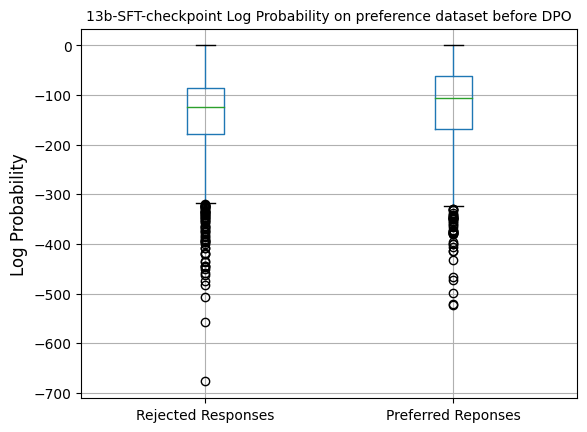

In [17]:
import matplotlib.pyplot as plt
df[['ref_rej_logp', 'ref_win_logp']].boxplot()

plt.title('13b-SFT-checkpoint Log Probability on preference dataset before DPO', fontsize=10)

# Set the x-ticks
plt.xticks([1, 2], ['Rejected Responses', 'Preferred Reponses'])
plt.ylabel('Log Probability', fontsize=12)

# Save the plot in high DPI and PDF format
#
plt.show()


In [ ]:
def _convert_to_llava_answer_turn(answer):
    return {"from": "gpt", "value": answer}



In [2]:
df_reload['chosen'] = df_reload['chosen'].apply(_convert_to_llava_answer_turn)
df_reload['rejected'] = df_reload['rejected'].apply(_convert_to_llava_answer_turn)

NameError: name 'df_reload' is not defined

In [3]:
df_reload['rejected']

NameError: name 'df_reload' is not defined

In [7]:
df.to_json('/home/ubuntu/LLaVA/playground/data/dpo/dpo_logp.json', orient='records')


# Old draft below

In [8]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, load_image_from_base64, get_model_name_from_path

from PIL import Image
import math
disable_torch_init()
model_path = '/home/ubuntu/LLaVA/checkpoints/llava-v1.5-13b'
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


.....Loading vision tower and image processor...


In [9]:
use_im_start_end= False # Default setting from llava 1.5 

IMAGE_FOLDER='/home/ubuntu/train2017'


In [10]:
# Inspect previous setup

df_muffin_tsv = '/home/ubuntu/muffin/data/RLHF-V-Hall_v0/RLHF-V-Hall_v0-1837.tsv'
df = pd.read_csv(df_muffin_tsv, sep='\t')

In [11]:
from llava.train.train import encode_multimodal_preference_sample
import torch.utils.data as torch_data

class PreferenceInferenceDataset(torch_data.Dataset):
    def __init__(self,
                 data_path,
                 tokenizer,
                 img_processor,
                 use_im_start_end):
        self.data = pd.read_csv(data_path, sep='\t')

        self.mm_cfg = {
            'image_processor': img_processor,
            'is_multimodal': True,
            # 'image_token_len': image_token_len, # TODO check if needed
            'use_im_start_end': use_im_start_end,
            'image_aspect_ratio': 'pad'
        }
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        # After encode multimodal preference sample, 
        # the image would ahve the pixel values values
        sample = self.convert_dataframe_row_to_source(self.data.iloc[index])
        rej_data_dict, win_data_dict = encode_multimodal_preference_sample(sample, self.tokenizer, self.mm_cfg)
        return rej_data_dict, win_data_dict
    
    def _get_image(self, img_filename):
        img_path = os.path.join(IMAGE_FOLDER, img_filename)
        image = Image.open(img_path).convert('RGB')
        return image
    

    def _convert_to_llava_answer_turn(self, answer):
        return {"from": "gpt", "value": answer}

    def convert_dataframe_row_to_source(self, row):
        dict_output = {'question': row['question'], 
                       # Chosen and rejected based on the sum of the first three quality score
                    'chosen': self._convert_to_llava_answer_turn(row['chosen']),
                    'rejected': self._convert_to_llava_answer_turn(row['rejected']),
                    'image': self._get_image(row['image'])}
        return dict_output

    def __len__(self):
        return len(self.data)
    
preference_torch_dataset = PreferenceInferenceDataset('/home/ubuntu/muffin/data/RLHF-V-Hall_v0/RLHF-V-Hall_v0-1837.tsv',
                           tokenizer=tokenizer,
                           img_processor=image_processor,
                           use_im_start_end=False)
preference_torch_dataset[0]

({'input_ids': tensor([    1,   319, 13563,  1546,   263, 12758,  1404,   322,   385, 23116,
          21082, 20255, 29889,   450, 20255,  4076,  8444, 29892, 13173, 29892,
            322,  1248,   568,  6089,   304,   278,  1404, 29915, 29879,  5155,
          29889,  3148,  1001, 29901,   529,  3027, 29958,    13, 11008,   338,
            445,  6808,   814,  5929, 12818,   304,  4856,   411,   263, 14225,
            304,   720, 29973,   319,  1799,  9047, 13566, 29901,   450,  6808,
            814,   297,   278,  1967, 29892,   607,  5680,   263,  8424,   310,
            274,  1296, 10664,   297,   377, 16242,   907,   314,   322,   521,
            542, 23167,   528,   485,   886, 29892,   723,   367, 10712,  5929,
          12818,   304,  4856,   411,   263, 14225,   304,   720, 29889,   910,
            338,  1363,   278,   274,  1296,  3528,  5692,   304,   367,   263,
           8261,   322, 29156,  5362,  7539, 29892,  1754,  1584,   901,   875,
          18499,   491,   2

In [12]:
preference_torch_dataset.mm_cfg['image_aspect_ratio']

'pad'

In [13]:
def _convert_to_llava_answer_turn(self, answer):
    return {"from": "gpt", "value": answer}

torch.Size([3, 336, 336])

In [14]:
preference_torch_dataset[0][0]['input_ids'].shape

torch.Size([226])

In [ ]:
from llava.train.train import preference_collator_fn
from functools import partial
import tqdm
from llava.train.llava_trainer import get_batch_logps
dataset = preference_torch_dataset
collate_fn = partial(preference_collator_fn, pad_token_id=tokenizer.pad_token_id)
dataloader = torch_data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn,
                                    num_workers=5, shuffle=False)
win_logp_list = []
rej_logp_list = []

win_avg_logp_list = []
rej_avg_logp_list = []

win_per_token_logp_list = []
rej_per_token_logp_list = []

with torch.inference_mode():
    for batch in tqdm.tqdm(dataloader):
        for key in ['win', 'rej']:
            input_ids = batch[f'{key}_input_ids'].cuda()
            labels = batch[f'{key}_labels'].cuda()
            attention_mask = batch[f'{key}_attention_mask'].cuda()

            output = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                images=batch['images'].half().cuda()
            )
            per_token_logp, log_prob, average_log_prob = get_batch_logps(output.logits, labels, return_all=True)

            # print(per_token_logp.shape, input_ids.shape, labels.shape, flush=True)
            assert per_token_logp.size(1) >= input_ids.size(1) - 1
            per_token_logp = per_token_logp.tolist()
            # per_token_logp = [x[:input_ids[i].ne(tokenizer.pad_token_id).sum().item()] for i, x in enumerate(per_token_logp)]
            log_prob = log_prob.tolist()
            average_log_prob = average_log_prob.tolist()

            if key == 'win':
                win_logp_list += log_prob
                win_avg_logp_list += average_log_prob
                win_per_token_logp_list += per_token_logp
            else:
                rej_logp_list += log_prob
                rej_avg_logp_list += average_log_prob
                rej_per_token_logp_list += per_token_logp
            # print(f'{key} logits in {output.logits.shape}, logp in {log_prob.shape} avg_logp in {average_log_prob.shape}')

In [14]:
next(iter(dataloader))

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/transformers/feature_extraction_utils.py", line 92, in __getattr__
    return self.data[item]
KeyError: 'shape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 808, in preference_collator_fn
    rej_batch = SFT_collator_fn(rej_instances, pad_token_id)
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 789, in SFT_collator_fn
    if all(x is not None and x.shape == images[0].shape for x in images):
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 789, in <genexpr>
    if all(x is not None and x.shape == images[0].shape for x in images):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/transformers/feature_extraction_utils.py", line 94, in __getattr__
    raise AttributeError
AttributeError


In [15]:
%debug

> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/_utils.py(644)reraise()
    642             # instantiate since we don't know how to
    643             raise RuntimeError(msg) from None
--> 644         raise exception
    645 
    646 

*** NameError: name 'images' is not defined
> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py(1371)_process_data()
   1369         self._try_put_index()
   1370         if isinstance(data, ExceptionWrapper):
-> 1371             data.reraise()
   1372         return data
   1373 

*** NameError: name 'images' is not defined
*** Invalid frame count (')
> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py(1345)_next_data()
   1343             else:
   1344                 del self._task_info[idx]
-> 1345                 return self._process_data(data)
   1346 
   1347     def _try_put_index(self):

> /home/ubuntu/mambaforge-